In [74]:
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit.algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.neural_networks import TwoLayerQNN, CircuitQNN
from qiskit.opflow import PauliSumOp
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
# https://qiskit.org/documentation/tutorials/operators/02_gradients_framework.html
from qiskit.opflow.gradients import Gradient #, NaturalGradient, QFI, Hessian

import time
import warnings
warnings.filterwarnings('ignore')

algorithm_globals.random_seed = 42


In [89]:
data = load_iris(as_frame = False)

In [76]:
X_data = data.data
Y_data = data.target

In [4]:
datad = pd.DataFrame(data=X_data, columns=data.feature_names)
datad.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
data.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

In [6]:
list(data.target_names)

['setosa', 'versicolor', 'virginica']

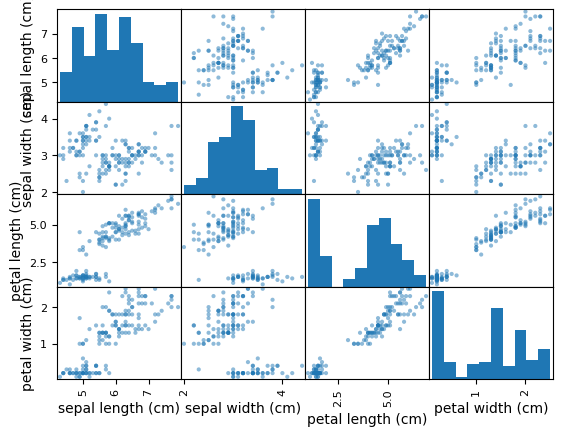

In [7]:
scatter_matrix(datad)
plt.show()

In [8]:
scaler_mm = MinMaxScaler()
X_data_temp = scaler_mm.fit_transform(X_data)
X_data_temp[:10]

array([[0.22222222, 0.625     , 0.06779661, 0.04166667],
       [0.16666667, 0.41666667, 0.06779661, 0.04166667],
       [0.11111111, 0.5       , 0.05084746, 0.04166667],
       [0.08333333, 0.45833333, 0.08474576, 0.04166667],
       [0.19444444, 0.66666667, 0.06779661, 0.04166667],
       [0.30555556, 0.79166667, 0.11864407, 0.125     ],
       [0.08333333, 0.58333333, 0.06779661, 0.08333333],
       [0.19444444, 0.58333333, 0.08474576, 0.04166667],
       [0.02777778, 0.375     , 0.06779661, 0.04166667],
       [0.16666667, 0.45833333, 0.08474576, 0.        ]])

In [9]:
ohe_transformer = OneHotEncoder(sparse = False)
Y_data_temp = ohe_transformer.fit_transform(Y_data.reshape(-1,1))
Y_data_temp[:10]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [10]:
features = X_data_temp.shape[1]
features

4

In [11]:
feature_map = ZZFeatureMap(feature_dimension = features, reps = 1, entanglement = "full")

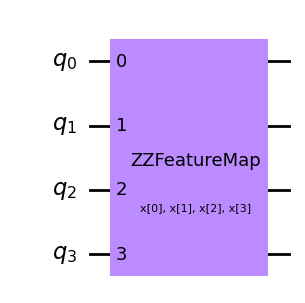

In [12]:
feature_map.draw('mpl')

In [13]:
num_qubits = features
variational_circ = EfficientSU2(num_qubits = num_qubits, reps = 4, entanglement = "full")

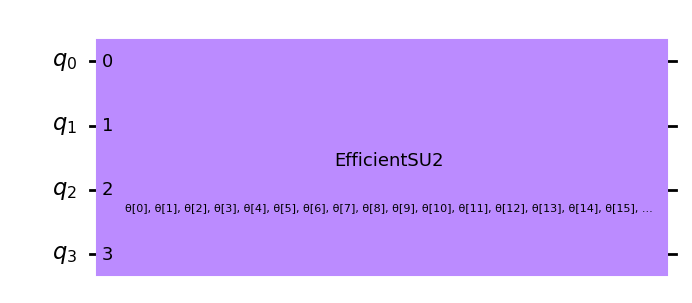

In [14]:
variational_circ.draw('mpl')

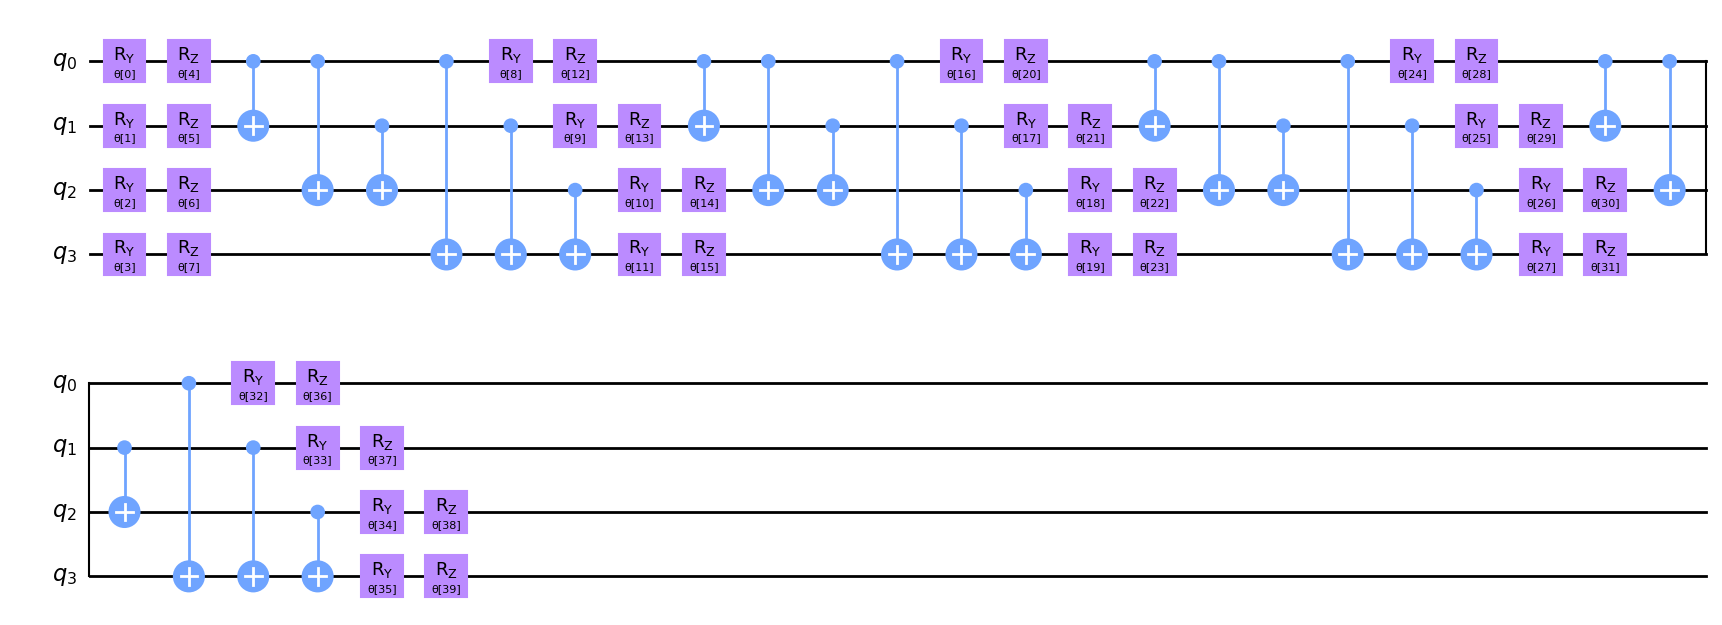

In [15]:
variational_circ.decompose().draw('mpl')

In [16]:
#qiskit azure libraries
from azure.quantum import Workspace
from azure.quantum.qiskit import AzureQuantumProvider

In [17]:
provider = AzureQuantumProvider (
    resource_id = "/subscriptions/27e69b46-e921-4667-9271-520949917c36/resourceGroups/AzureQuantum/providers/Microsoft.Quantum/Workspaces/qunttrial01",
    location = "East US")

In [18]:
print("This workspace's targets:")
for backend in provider.backends():
    print("- " + backend.name())

This workspace's targets:
- ionq.simulator
- ionq.simulator
- ionq.simulator
- ionq.qpu
- ionq.qpu
- ionq.qpu
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- ionq.qpu.aria-1
- quantinuum.hqs-lt-s1-apival
- quantinuum.hqs-lt-s1-apival
- quantinuum.sim.h1-1sc
- quantinuum.sim.h1-1sc
- quantinuum.hqs-lt-s2-apival
- quantinuum.hqs-lt-s2-apival
- quantinuum.sim.h1-2sc
- quantinuum.sim.h1-2sc
- quantinuum.hqs-lt-s1-sim
- quantinuum.hqs-lt-s1-sim
- quantinuum.sim.h1-1e
- quantinuum.sim.h1-1e
- quantinuum.hqs-lt-s2-sim
- quantinuum.hqs-lt-s2-sim
- quantinuum.sim.h1-2e
- quantinuum.sim.h1-2e
- quantinuum.hqs-lt-s1
- quantinuum.hqs-lt-s1
- quantinuum.qpu.h1-1
- quantinuum.qpu.h1-1
- quantinuum.hqs-lt-s2
- quantinuum.hqs-lt-s2
- quantinuum.qpu.h1-2
- quantinuum.qpu.h1-2
- rigetti.sim.qvm
- rigetti.qpu.aspen-m-3
- microsoft.estimator


In [19]:
backend = provider.get_backend("ionq.simulator")
print(backend)

ionq.simulator


In [20]:
# specify the observable
observable = PauliSumOp.from_list([("ZZ" * num_qubits, 1)])
print(observable)

1.0 * ZZZZZZZZ


In [21]:
quantum_instance = QuantumInstance(backend, 
                                   shots = 1024, 
                                   seed_simulator = algorithm_globals.random_seed, 
                                   seed_transpiler = algorithm_globals.random_seed)

In [25]:
two_layers = False

if two_layers:
    
    qnn_architecture = TwoLayerQNN(
        num_qubits, 
        feature_map=feature_map, 
        ansatz=variational_circ, 
        observable=observable, 
        quantum_instance=quantum_instance
    )

else:
    
    num_inputs = features

    # construct quantum circuit
    qc = QuantumCircuit(num_inputs)
    qc.append(feature_map, range(num_inputs))
    qc.append(variational_circ, range(num_inputs))
    qc.decompose().draw(output="mpl")

    # parity maps bitstrings to 0 or 1
    def parity(x):
        return "{:b}".format(x).count("1") % 2

    output_shape = len(np.unique(Y_data))  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

    # construct QNN
    qnn_architecture = CircuitQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=variational_circ.parameters,
        interpret=parity,
        output_shape=output_shape,
        gradient=Gradient(),
        quantum_instance=quantum_instance,
    )


In [26]:
# define (random) input and weights
input3 = algorithm_globals.random.random(qnn_architecture.num_inputs)
weights3 = algorithm_globals.random.random(qnn_architecture.num_weights)

In [27]:
# QNN forward pass
qnn_architecture.forward(input3, weights3)

seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored


......

array([[0.58984375, 0.41015625, 0.        ]])

In [132]:
# QNN backward pass
qnn_architecture.backward(input3, weights3)

seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and 

.................................................................................

(None,
 array([[[-0.02636719, -0.02880859,  0.04785156, -0.01806641,
           0.04931641,  0.11035156, -0.04931641, -0.08691406,
          -0.00195313,  0.07763672, -0.00634766, -0.08300781,
           0.01220703, -0.00585937, -0.01220703,  0.02490234,
           0.00927734, -0.06689453,  0.00927734,  0.04199219,
          -0.02246094, -0.00097656, -0.04882813, -0.03857422,
          -0.00146484, -0.02636719, -0.1015625 , -0.05664063,
          -0.00927734, -0.02539063,  0.00097656, -0.04833984,
           0.18115234, -0.13085938, -0.04052734,  0.02734375,
           0.01367188, -0.00097656, -0.00341797,  0.00097656],
         [ 0.02636719,  0.02880859, -0.04785156,  0.01806641,
          -0.04931641, -0.11035156,  0.04931641,  0.08691406,
           0.00195312, -0.07763672,  0.00634766,  0.08300781,
          -0.01220703,  0.00585937,  0.01220703, -0.02490234,
          -0.00927734,  0.06689453, -0.00927734, -0.04199219,
           0.02246094,  0.00097656,  0.04882812,  0.03857422,


In [28]:
X_data.shape

(150, 4)

In [29]:
Y_data.shape

(150,)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_data_temp, Y_data_temp, test_size=0.2, random_state=algorithm_globals.random_seed)

In [31]:
X_train.shape

(120, 4)

In [48]:
Y_data.shape

(150,)

<h2> Classical Execution </h2>

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [172]:
#activation functions 
def sig(x): # sigmoid function
    return 1 / (1 + np.exp(-x))

def soft(x): #softmax layer
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / np.sum(e_x, axis=1, keepdims=True)


In [173]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Initialize weights and biases
        self.W1 = np.random.randn(self.input_size, self.hidden_size) * 0.01
        self.b1 = np.zeros((1, self.hidden_size))
        self.W2 = np.random.randn(self.hidden_size, self.output_size) * 0.01
        self.b2 = np.zeros((1, self.output_size))

    def forward(self, X):
        # Forward pass
        self.z1 = np.dot(X, self.W1) + self.b1
        self.a1 = sig(self.z1)
        self.z2 = np.dot(self.a1, self.W2) + self.b2
        self.probs = soft(self.z2)
        return self.probs

    def backward(self, X, y, learning_rate):
        m = X.shape[0]

        #  gradients calculation
        delta3 = self.probs
        delta3[range(m), y] -= 1
        delta3 /= m

        dW2 = np.dot(self.a1.T, delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)

        delta2 = np.dot(delta3, self.W2.T) * (self.a1 * (1 - self.a1))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Update weights and biases using gradient descent
        self.W2 -= learning_rate * dW2
        self.b2 -= learning_rate * db2
        self.W1 -= learning_rate * dW1
        self.b1 -= learning_rate * db1

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            # Forward and backward pass
            probs = self.forward(X)
            self.backward(X, y, learning_rate)

            # Calculate the loss (cross-entropy loss)
            loss = -np.log(probs[range(len(y)), y]).mean()
            
            # Print the loss at each epoch
            if epoch % 100 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss:.4f}")

    def predict(self, X):
        # Make predictions using the trained model
        return np.argmax(self.forward(X), axis=1)


In [185]:
# Set the hyperparameters
input_size = X_train.shape[1]
hidden_size = 8
output_size = 3
learning_rate = 0.1
epochs = 1000

model = NeuralNetwork(input_size, hidden_size, output_size)

model.train(X_train, y_train, epochs, learning_rate)

predictions = model.predict(X_test)

accuracy = np.mean(predictions == y_test)
print(f'Test accuracy: {accuracy:.4f}')

Epoch 0/1000, Loss: nan
Epoch 100/1000, Loss: nan
Epoch 200/1000, Loss: nan
Epoch 300/1000, Loss: nan
Epoch 400/1000, Loss: nan
Epoch 500/1000, Loss: nan
Epoch 600/1000, Loss: nan
Epoch 700/1000, Loss: nan
Epoch 800/1000, Loss: nan
Epoch 900/1000, Loss: nan
Test accuracy: 0.9667


<h1> Quntum Execution </h1> 

In [43]:
optimizer = COBYLA(maxiter =1 , tol = 0.001)

In [44]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [45]:
qnnc = NeuralNetworkClassifier(qnn_architecture, optimizer=optimizer, callback=callback_graph)


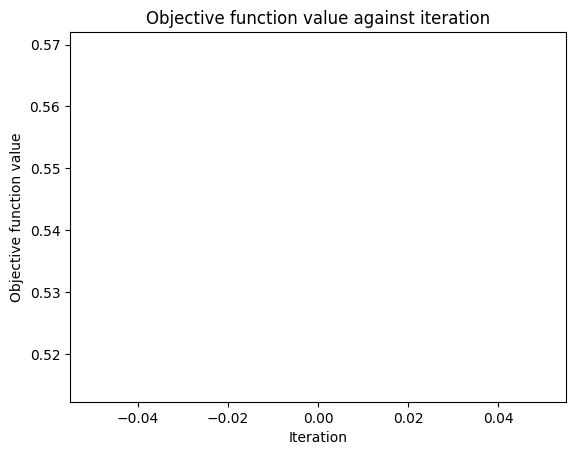

Training time: 393 seconds


In [38]:
objective_func_vals = []
y_train_fit = y_train.T[0]
start = time.time()
qnnc.fit(X_train, y_train_fit)
elapsed = time.time() - start
print(f"Training time: {round(elapsed)} seconds")

In [142]:
# plt.rcParams['figure.figsize'] = [10, 7]

# objective_func_vals = []

# y_train_fit = y_train.T[0]

# qnnc.fit(X_train, y_train_fit)

# elapsed = time.time() - start

# print("Time elapsed: ", elapsed)

# plt.show()

In [41]:
print("Train score: {:.2f} %".format(qnnc.score(X_train, y_train_fit)*100))

y_test_score = np.array(y_test).T[0]

print("Test score: {:.2f} %".format(qnnc.score(X_test, y_test_score)*100))

seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and 

..........................................................................................................................................................Train score: 37.50 %


seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and will be ignored
seed_simulator is not a known attribute of class <class 'azure.quantum._client.models._models.JobDetails'> and 

........................................Test score: 33.33 %
